In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_001b import *
from PIL import Image
import PIL, matplotlib.pyplot as plt
from torch.utils.data import Dataset

# CIFAR subset data

## Setup

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

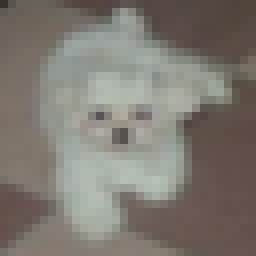

In [4]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

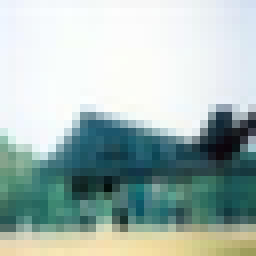

In [5]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

In [55]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    classes.sort(key=lambda d: d.name)
    return classes

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = np.array(image, dtype=np.float32)/255.
    if len(arr.shape)==2: arr = np.repeat(arr[...,None],3,2)
    return torch.from_numpy(arr)

In [56]:
class FilesDataset(Dataset):
    def __init__(self, folder, classes):
        self.fns, self.y = [], []
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [57]:
# NB: validation or training may not have all classes
classes = [cls.name for cls in find_classes(PATH/'train')]

train_ds = FilesDataset(PATH/'train', classes)
valid_ds = FilesDataset(PATH/'test', classes)

In [9]:
len(train_ds), len(valid_ds)

(10000, 2000)

airplane


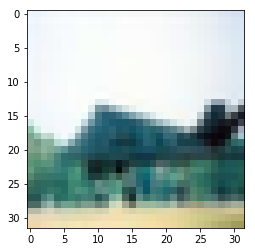

In [10]:
x,y = train_ds[0]
plt.imshow(x.numpy())
print(train_ds.classes[y])

In [11]:
import torch
default_device = torch.device('cuda', 0)

In [12]:
bs=64

In [13]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [121]:
def show_image(img, ax=None, figsize=(3,3)):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img.cpu().numpy())
    ax.axis('off')

def show_image_batch(dl, classes, rows=None):
    if rows is None: rows = int(math.sqrt(len(x)))
    x,y = next(iter(dl))[:rows*rows]
    show_images(x,y,rows, classes)

def show_images(x,y,rows, classes):
    fig, axs = plt.subplots(rows,rows,figsize=(12,15))
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

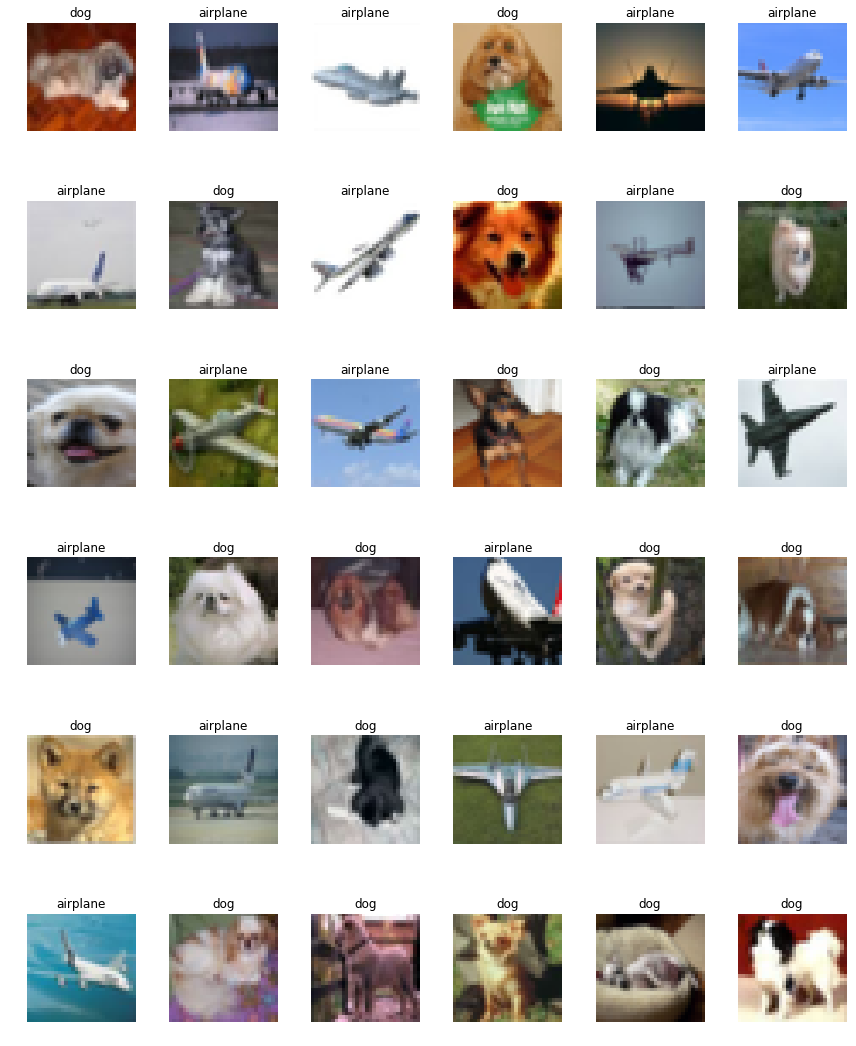

In [15]:
show_image_batch(data.train_dl, classes, 6)

## Simplify transforms

In [16]:
def get_batch_stats(dl):
    x,_ = next(iter(dl))
    return x.view([-1,3]).mean(0), x.view([-1,3]).std(0)

In [17]:
data_mean,data_std = get_batch_stats(data.train_dl)
data_mean,data_std

(tensor([0.5479, 0.5403, 0.5205], device='cuda:0'),
 tensor([0.2437, 0.2506, 0.2783], device='cuda:0'))

In [18]:
noop = lambda x: x

def xy_transform(x_tfm=None, y_tfm=None):
    if x_tfm is None: x_tfm = noop
    if y_tfm is None: y_tfm = noop
    return lambda b: (x_tfm(b[0]), y_tfm(b[1]))

def xy_transforms(x_tfms=None, y_tfms=None):
    x_tfms = listify(x_tfms)
    if y_tfms is None: y_tfms=noop
    y_tfms = listify(y_tfms, x_tfms)
    return list(map(xy_transform, x_tfms, y_tfms))

In [19]:
def normalize(mean,std,x): return (x-mean)/std
def channel_first(x): return x.permute([0,3,1,2])

In [21]:
cifar_transforms = [
    partial(normalize, data_mean, data_std),
    channel_first
]

cifar_xy_transforms = xy_transforms(cifar_transforms)

In [22]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfms=cifar_xy_transforms, valid_tfms=cifar_xy_transforms)
len(data2.train_dl), len(data2.valid_dl)

(157, 16)

In [23]:
x,y = next(iter(data2.train_dl))
x.shape

torch.Size([64, 3, 32, 32])

In [24]:
x = (x.permute([0,2,3,1])*data_std)+data_mean
x.shape

torch.Size([64, 32, 32, 3])

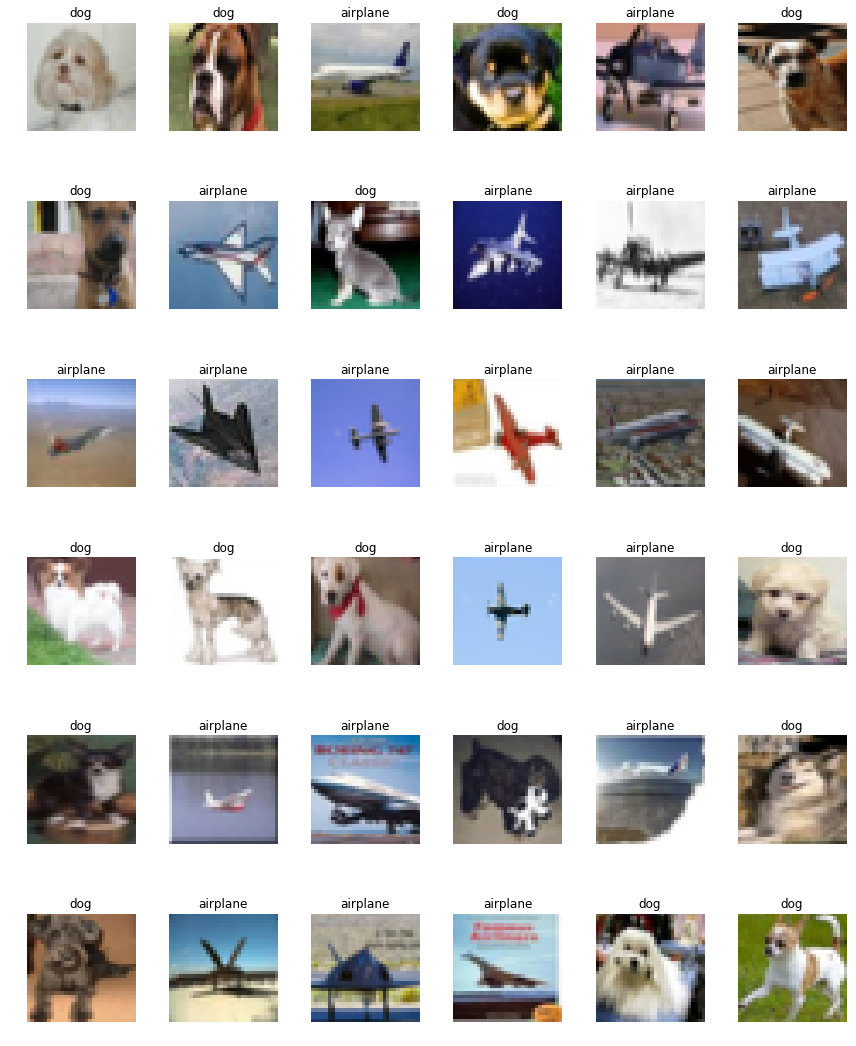

In [25]:
show_images(x,y,6,classes)

In [26]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [27]:
learn.fit(2, 0.1)

0 0.4295282173156738


1 0.2993863673210144



## Random transforms

In [109]:
def brightness(x, pct_change):
    x *= (1+pct_change)
    return x.clamp_(0,1)

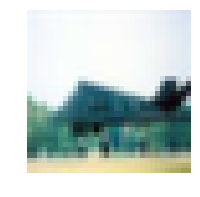

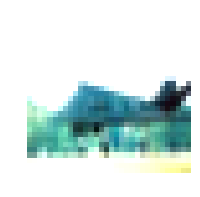

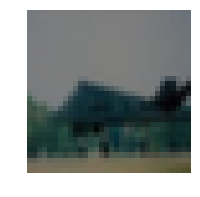

In [123]:
show_image(train_ds[0][0])
show_image(brightness(train_ds[0][0],0.5))
show_image(brightness(train_ds[0][0],-0.5))

In [80]:
from numpy import random

random_cfg = {
    'brightness': {
        'pct_change': partial(random.uniform, low=-0.5, high=0.5)
    }
}

In [111]:
def func_rand_kw(func, cfg):
    func_cfg = cfg[func.__name__]
    return {k:v() for k,v in func_cfg.items()}
    
def func_rand(func, cfg):
    return lambda x: func(x, **func_rand_kw(func, cfg))

In [112]:
brightness_rand = func_rand(brightness, random_cfg)

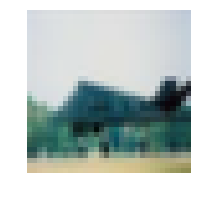

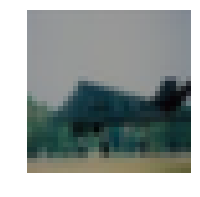

In [122]:
show_image(brightness_rand(train_ds[0][0]))
show_image(brightness_rand(train_ds[0][0]))

# Darknet

In [29]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [30]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [37]:
model = Darknet([1, 2, 4, 6, 3], num_classes=2, nf=32)
learner = Learner(data2, model)

In [38]:
learner.fit(1, 0.01, opt_fn=partial(optim.SGD, momentum=0.9))

0 0.7355462017059327


In [39]:
learner.fit(2, 0.05)

0 0.469083972454071


1 0.16272257494926454


In [40]:
learner.fit(1, 0.01)

0 0.14141892766952516


1 0.14167725318670274


# Sylvain's transforms

## Add transforms

In [57]:
from enum import IntEnum

class TfmType(IntEnum):
    NO = 1
    PIXEL = 2
    COORD = 3
    CLASS = 4

In [58]:
from abc import abstractmethod

class Transform():
    
    def __init__(self, tfm_y=TfmType.NO, p=1, batch_lvl = False):
        self.tfm_y,self.p,self.batch_lvl = tfm_y,p,batch_lvl
    
    def __call__(self, x, y):
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y
    
    def set_device(self, device):
        if not self.batch_lvl: self.device = device
    
    def transform_coord(self, x, y):
        if self.p == 1 or np.random.rand < self.p:
            return self.transform(x),y

    def transform(self, x, y=None):
        if self.p == 1 or np.random.rand < self.p:
            x = self.do_transform(x,False)
            return (x, self.do_transform(y,True)) if y is not None else x
        else: return x,y
    
    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError
    #In do_transform we can save a value (angle of a random rotation for instance) in self.save_for_y that will be used
    #if is_y is True.

In [60]:
class ChannelOrder(Transform):
    #If we use PIL for data augmentation, maybe the conversion to a numpy array should be handled here?
    def __init__(self, tfm_y=TfmType.NO):
        super().__init__(tfm_y=tfm_y)
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL: x = np.rollaxis(x, 2)
        return x

In [61]:
class Normalize(Transform):
    
    def __init__(self, means, stds, tfm_y=TfmType.NO):
        self.means,self.stds = means,stds
        super().__init__(tfm_y=tfm_y, batch_lvl=True)
    
    def set_device(self, device):
        super().set_device(device)
        if type(self.means) != torch.Tensor or not self.means.device == device:
            self.means,self.stds = map(lambda x:torch.Tensor(x).to(device), (self.means, self.stds))
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL:
            m, s = self.means[None,:,None,None].type_as(x), self.stds[None,:,None,None].type_as(x)
            x = (x - m) / s
        return x

In [62]:
def compose(tfms, x, y):
    for tfm in tfms: x,y = tfm(x,y)
    return x,y

In [84]:
def split_one_tfms(tfms):
    ds_tfms = [tfm for tfm in tfms if not tfm.batch_lvl]
    dl_tfms = [tfm for tfm in tfms if tfm.batch_lvl]
    return ds_tfms,dl_tfms
    
def split_tfms(trn_tfms, val_tfms):
    trn_ds_tfms, trn_dl_tfms = split_one_tfms(trn_tfms)
    val_ds_tfms, val_dl_tfms = split_one_tfms(val_tfms)
    return trn_ds_tfms, val_ds_tfms, trn_dl_tfms, val_dl_tfms